In [4]:
import pandas as pd
import mysql.connector

# Connect to MySQL
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="Arghya@",
    database="retail_db"
)

# Load sales_clean table into pandas
df = pd.read_sql("SELECT * FROM sales_clean", conn)
conn.close()

df.head()


C:\Users\91629\AppData\Local\Temp\ipykernel_31612\3841697708.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM sales_clean", conn)


,TransactionID,InvoiceNo,InvoiceDate,CustomerID,ProductID,Quantity,UnitPrice,DiscountPct,TotalPrice,Description,Category
0,1,INV03383,2022-01-01 01:00:00,CUST0150,PROD034,2,459.18,0.0,918.36,Product 34,Toys
1,2,INV01531,2022-01-01 02:00:00,CUST0163,PROD013,2,79.21,15.0,134.66,Product 13,Grocery
2,3,INV03904,2022-01-01 04:00:00,CUST0060,PROD033,1,36.22,10.0,32.60,Product 33,Toys
3,4,INV00729,2022-01-01 07:00:00,CUST0230,PROD033,2,437.73,15.0,744.14,Product 33,Toys
4,5,INV04255,2022-01-01 10:00:00,CUST0336,PROD031,2,202.61,10.0,364.70,Product 31,Home & Kitchen


##Exploratory Data Analysis

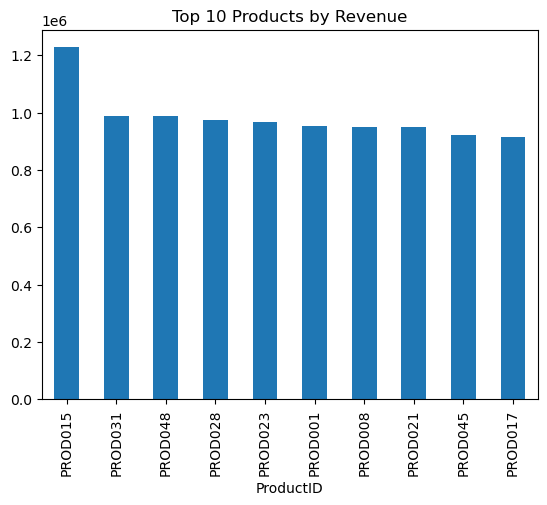

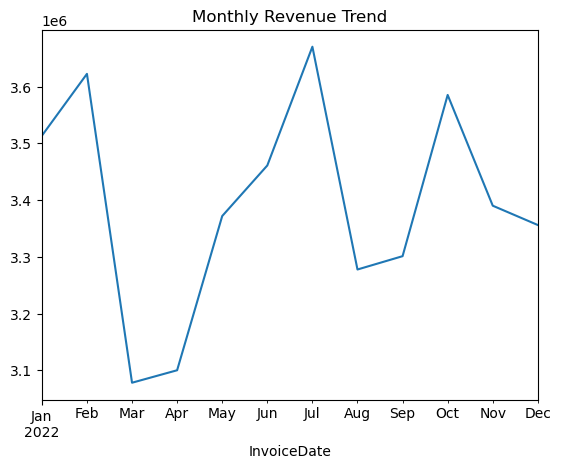

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top 10 products
top_products = df.groupby("ProductID")["TotalPrice"].sum().nlargest(10)
top_products.plot(kind="bar", title="Top 10 Products by Revenue")
plt.show()

# Revenue trend over time
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
revenue_trend = df.groupby(df["InvoiceDate"].dt.to_period("M"))["TotalPrice"].sum()
revenue_trend.plot(kind="line", title="Monthly Revenue Trend")
plt.show()


In [8]:
import datetime as dt

# Snapshot date = last transaction + 1 day
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,   # Recency
    "InvoiceNo": "nunique",                                    # Frequency
    "TotalPrice": "sum"                                        # Monetary
})

rfm.rename(columns={
    "InvoiceDate": "Recency",
    "InvoiceNo": "Frequency",
    "TotalPrice": "Monetary"
}, inplace=True)

rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
CUST0001,168,7,54285.56
CUST0002,79,6,55138.16
CUST0003,6,10,68649.56
CUST0004,93,8,46580.80
CUST0005,39,9,69262.20


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Scale features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Apply KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)

rfm.groupby("Cluster").mean()


,Recency,Frequency,Monetary
Cluster,,,
0,27.823129,7.394558,55137.994286
1,27.437500,13.875000,126662.913125
2,24.975248,10.792079,85571.676040
3,117.018182,7.290909,57791.386545


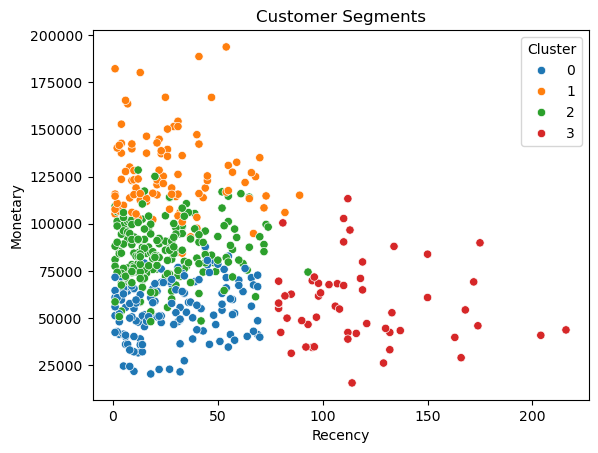

In [12]:
sns.scatterplot(x="Recency", y="Monetary", hue="Cluster", data=rfm, palette="tab10")
plt.title("Customer Segments")
plt.show()
